In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
from torchsummary import summary
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [3]:
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

In [4]:
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
if torch.cuda.is_available: device = 'cuda'
else: device = 'cpu'

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)
test_data

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
train_batch_size = 32
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images.size()

torch.Size([32, 3, 32, 32])

# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [6]:
class ConvolutionModel(nn.Module):
    def __init__(self):
        super(ConvolutionModel, self).__init__()
        # Initialize the layers
        self.conv1 = nn.Conv2d(3, 24, 1) #(number of input channels, number of output channels, stride of sliding window)
        self.conv2 = nn.Conv2d(24, 48, 1)
        self.conv3 = nn.Conv2d(48, 96, 1)
        # rand_tensor = torch.rand((1, 3, 32, 32))
        
        self.fc1 = nn.Linear(1536, 120) #(number of input channels, number of output channels)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, len(classes))
        self.pool = nn.MaxPool2d(2, 2) #(region size to pool (2x2), stride of sliding window)
        # print(np.prod(self.pool(self.conv3(self.pool(self.conv2(self.pool(self.conv1(rand_tensor)))))).shape))

    # Call the layers on an image
    def forward(self, x):
        batch_size, channels, length, width = x.shape
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = ConvolutionModel().to(device=device)

In [7]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]              96
         MaxPool2d-2           [-1, 24, 16, 16]               0
            Conv2d-3           [-1, 48, 16, 16]           1,200
         MaxPool2d-4             [-1, 48, 8, 8]               0
            Conv2d-5             [-1, 96, 8, 8]           4,704
         MaxPool2d-6             [-1, 96, 4, 4]               0
            Linear-7                  [-1, 120]         184,440
            Linear-8                   [-1, 60]           7,260
            Linear-9                   [-1, 10]             610
Total params: 198,310
Trainable params: 198,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.41
Params size (MB): 0.76
Estimated Total Size (MB): 1.18
-------------------------------------------

In [8]:
m = model(images[0].cuda().unsqueeze(0))
m

tensor([[ 0.0767, -0.0993,  0.1071, -0.0176,  0.1081,  0.0547, -0.0761, -0.0359,
          0.0172, -0.0696]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [9]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
loop = tqdm(total=epochs, position=0)
first = True
mean_losses = []
accuracies = []

for epoch in range(epochs):
    if first: loop.set_description('loss:{:.4f}'.format(-1))
    if not first: loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update()
    model.train()
    losses = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad() # Zero out the the gradients
        outputs = model(inputs) # Run the model
        loss = objective(outputs, labels) # Calculate loss
        loss.backward() # Compute gradients
        optimizer.step() # Optimize and update the weights

        losses.append(loss.item())
    model.eval()
    mean_loss = np.mean(losses)
    mean_losses.append(mean_loss)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)

    first = False
        

loss:1.4738: 100%|██████████| 10/10 [04:23<00:00, 27.85s/it]

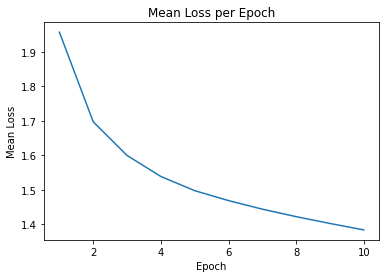

In [59]:
plt.plot(range(1, len(mean_losses) + 1), mean_losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
plt.title("Mean Loss per Epoch")
plt.show()

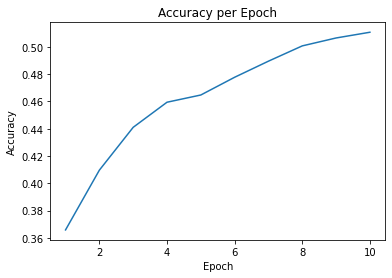

In [60]:
plt.plot(range(1, len(accuracies) + 1), accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [1]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: ships  Predicted: trucks
Epsilon = 0


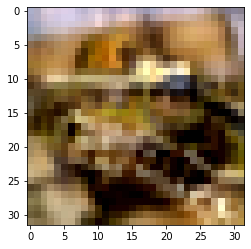

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: cars  Predicted: deer
Epsilon = 0.05


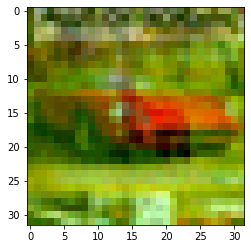

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: dogs  Predicted: horses
Epsilon = 0.1


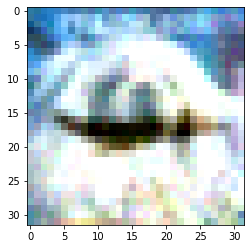

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: cats  Predicted: horses
Epsilon = 0.15


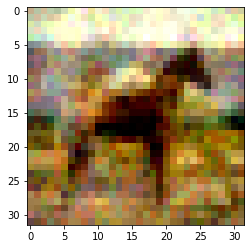

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: deer  Predicted: horses
Epsilon = 0.2


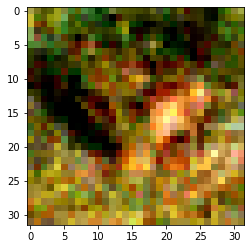

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: cars  Predicted: trucks
Epsilon = 0.25


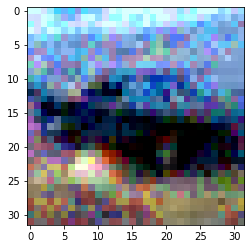

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: frogs  Predicted: cars
Epsilon = 0.3


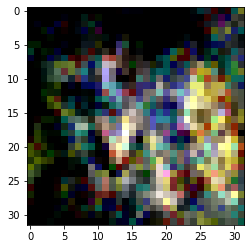

In [62]:
accuracies = []
noises = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        images.requires_grad = True
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        if predicted != labels:
            continue
        
        # correct predictions
        loss = objective(outputs, labels) # Calculate loss
        optimizer.zero_grad() # Zero out the the gradients
        loss.backward() # Compute gradients

        data_grad = images.grad.data
        perturbed_data = fgsm_attack(images, eps, data_grad)
        outputs = model(perturbed_data)
        noise = perturbed_data.squeeze().detach().cpu().numpy()
        noises.append(noise)
    correct = 0
    total = 0
    with torch.no_grad():
        first = True
        for data in test_loader:
            images, labels = data
            noisy = images.cuda() + perturbed_data
            outputs = model(noisy)
            _, predicted = torch.max(outputs.data, 1)
            if first:
                print("Actual: " + classes[labels.item()] + "  Predicted: " + classes[predicted])
                print("Epsilon = " + str(eps))
                out_img = noisy.squeeze(0).cpu()/ 2 + 0.5
                out_img = np.transpose(out_img, (1, 2, 0))
                plt.imshow(out_img)
                plt.show()
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()
            first = False
    accuracy = correct / total
    accuracies.append(accuracy)
        


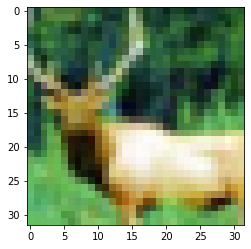

In [46]:
img = images[0].cpu()/ 2 + 0.5
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

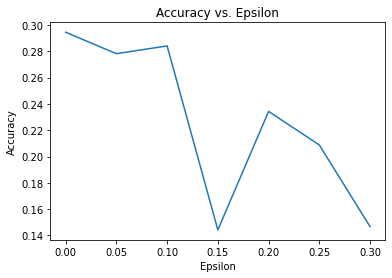

In [47]:
plt.plot(epsilons, accuracies)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epsilon")
plt.show()